# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [1]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [2]:
from sklearn.model_selection import train_test_split
y = df.salary_in_usd
X = df.drop('salary_in_usd', axis=1).drop('salary', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=0.8, 
    random_state=42,
)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, 
    train_size=0.5, 
    random_state=42,
)

In [3]:
X_train.shape, X_val.shape, X_test.shape, X.shape

((3004, 9), (376, 9), (375, 9), (3755, 9))

Я удалил признак salary, так как это практически таргет, только в разных валютах

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import warnings
warnings.filterwarnings("ignore")

categorical_features = X_train.columns[(X_train.dtypes == "object").values].tolist()
real_features = X_train.columns[(X_train.dtypes != "object").values].tolist()

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_val_encoded = encoder.transform(X_val[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])

X_train_ = np.hstack([X_train[real_features], X_train_encoded])
X_val_ = np.hstack([X_val[real_features], X_val_encoded])
X_test_ = np.hstack([X_test[real_features], X_test_encoded])

linear_model = LinearRegression()
linear_model.fit(X_train_, y_train)

val_predict = linear_model.predict(X_val_)
test_predict = linear_model.predict(X_test_)

print('MAPE val: ', mean_absolute_percentage_error(y_val, val_predict))
print('MAPE test: ', mean_absolute_percentage_error(y_test, test_predict))
      
print('RMSE val: ', mean_squared_error(y_val, val_predict, squared=False))
print('RMSE test: ', mean_squared_error(y_test, test_predict, squared=False))

MAPE val:  170337.11743840063
MAPE test:  567275.0147346829
RMSE val:  38462230721.41857
RMSE test:  76339664068.03265


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [52]:
# !pip install optuna

In [5]:
from xgboost.sklearn import XGBRegressor
import optuna

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e-1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e-1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e-1),
    }

    model = XGBRegressor(**params)
    model.fit(X_train_, y_train)

    y_val_pred = model.predict(X_val_)
    val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
    val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)

    return val_mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=75)

best_params = study.best_params
print("Best params: ", best_params)

[I 2024-06-08 22:09:03,614] A new study created in memory with name: no-name-8f930f45-6b13-4869-9c10-87e743791359
[I 2024-06-08 22:09:04,692] Trial 0 finished with value: 0.3316650242093894 and parameters: {'max_depth': 8, 'learning_rate': 0.06697992996636502, 'n_estimators': 457, 'gamma': 0.0002472240435438522, 'subsample': 0.8408307217854799, 'colsample_bytree': 0.8802297182755522, 'reg_alpha': 0.001507129579255289, 'reg_lambda': 0.09123070534045999}. Best is trial 0 with value: 0.3316650242093894.
[I 2024-06-08 22:09:05,201] Trial 1 finished with value: 0.49344619847817195 and parameters: {'max_depth': 4, 'learning_rate': 0.0015547725884630104, 'n_estimators': 387, 'gamma': 0.003999811222969936, 'subsample': 0.5007496612824951, 'colsample_bytree': 0.9983512794009335, 'reg_alpha': 0.0016282487462478423, 'reg_lambda': 0.0005925219954899986}. Best is trial 0 with value: 0.3316650242093894.
[I 2024-06-08 22:09:05,475] Trial 2 finished with value: 0.6131268853083641 and parameters: {'max

Best params:  {'max_depth': 8, 'learning_rate': 0.036680449547125196, 'n_estimators': 435, 'gamma': 0.00022031873858366339, 'subsample': 0.7847912943869709, 'colsample_bytree': 0.9020090831576235, 'reg_alpha': 0.0006481681636041503, 'reg_lambda': 0.0001670431871727745}


In [6]:
import time

xgb_model = XGBRegressor(**best_params)

start_time = time.time()
xgb_model.fit(X_train_, y_train)
training_time = time.time() - start_time


val_predict = xgb_model.predict(X_val_)

start_time = time.time()
test_predict = xgb_model.predict(X_test_)
prediction_time = time.time() - start_time

val_mape = mean_absolute_percentage_error(y_val, val_predict)
test_mape = mean_absolute_percentage_error(y_test, test_predict)

val_rmse = mean_squared_error(y_val, val_predict, squared=False)
test_rmse = mean_squared_error(y_test, test_predict, squared=False)

print('MAPE val: ', val_mape)
print('MAPE test: ', test_mape)

print('RMSE val: ', val_rmse)
print('RMSE test: ', test_rmse)

print('Training time: ', training_time)
print('Prediction time: ', prediction_time)

MAPE val:  0.32755493986053186
MAPE test:  0.3853534243911234
RMSE val:  52002.65898262161
RMSE test:  46049.399862946375
Training time:  0.9768226146697998
Prediction time:  0.0015192031860351562


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [61]:
# !pip install catboost

In [7]:
from catboost import CatBoostRegressor

def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 1e-1),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-4, 1e-1),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 1e-4, 1e-1),
        'border_count': trial.suggest_int('border_count', 32, 255),
    }

    model = CatBoostRegressor(**params, silent=True, random_state=42)
    model.fit(X_train_, y_train)

    y_val_pred = model.predict(X_val_)
    val_mape = mean_absolute_percentage_error(y_val, y_val_pred)

    return val_mape

# Создание объекта для поиска лучших гиперпараметров
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=75)

# Оптимальные гиперпараметры
best_params = study.best_params
print("Best params: ", best_params)

[I 2024-06-08 22:10:14,373] A new study created in memory with name: no-name-44f92db3-f33f-48c0-a6ef-8645b5659335
[I 2024-06-08 22:10:16,788] Trial 0 finished with value: 0.49158914394121844 and parameters: {'depth': 9, 'learning_rate': 0.0011432040761145952, 'iterations': 545, 'l2_leaf_reg': 0.0012698906082483847, 'random_strength': 0.00026591431930426994, 'bagging_temperature': 0.0039768485590080255, 'border_count': 175}. Best is trial 0 with value: 0.49158914394121844.
[I 2024-06-08 22:10:18,150] Trial 1 finished with value: 0.5699857089026171 and parameters: {'depth': 9, 'learning_rate': 0.0007856826857628055, 'iterations': 310, 'l2_leaf_reg': 0.019284442215361044, 'random_strength': 0.00029212665108687444, 'bagging_temperature': 0.004547019081931856, 'border_count': 183}. Best is trial 0 with value: 0.49158914394121844.
[I 2024-06-08 22:10:18,945] Trial 2 finished with value: 0.3396538043261144 and parameters: {'depth': 6, 'learning_rate': 0.06210815264822178, 'iterations': 335, '

Best params:  {'depth': 9, 'learning_rate': 0.03297000241296348, 'iterations': 400, 'l2_leaf_reg': 0.0031030976202747447, 'random_strength': 0.004862569236871496, 'bagging_temperature': 0.0002429582227974827, 'border_count': 182}


In [8]:
catboost_model = CatBoostRegressor(**best_params, silent=True)

start_time = time.time()
catboost_model.fit(X_train_, y_train)
training_time = time.time() - start_time


val_predict = catboost_model.predict(X_val_)

start_time = time.time()
test_predict = catboost_model.predict(X_test_)
prediction_time = time.time() - start_time

val_mape = mean_absolute_percentage_error(y_val, val_predict)
test_mape = mean_absolute_percentage_error(y_test, test_predict)

val_rmse = mean_squared_error(y_val, val_predict, squared=False)
test_rmse = mean_squared_error(y_test, test_predict, squared=False)

print('MAPE val: ', val_mape)
print('MAPE test: ', test_mape)

print('RMSE val: ', val_rmse)
print('RMSE test: ', test_rmse)

print('Training time: ', training_time)
print('Prediction time: ', prediction_time)

MAPE val:  0.33848716343769714
MAPE test:  0.40095532100174197
RMSE val:  50247.088979065484
RMSE test:  45167.107151096185
Training time:  1.8490910530090332
Prediction time:  0.02255702018737793


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [32]:
from catboost import Pool

train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=categorical_features)

def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 1e-1),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-4, 1e-1),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 1e-4, 1e-1),
        'border_count': trial.suggest_int('border_count', 32, 255),
    }

    model = CatBoostRegressor(**params, silent=True)
    model.fit(train_pool)

    y_val_pred = model.predict(val_pool)
    val_mape = mean_absolute_percentage_error(y_val, y_val_pred)

    return val_mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15, timeout=500)

best_params = study.best_params
print("Best params: ", best_params)

[I 2024-06-08 22:20:35,570] A new study created in memory with name: no-name-ecfd2efa-1787-4e38-b62a-4715612caefa
[I 2024-06-08 22:20:51,344] Trial 0 finished with value: 0.37709835089274 and parameters: {'depth': 5, 'learning_rate': 0.004981326723827293, 'iterations': 918, 'l2_leaf_reg': 0.015579119054614402, 'random_strength': 0.0043173783073663765, 'bagging_temperature': 0.000908531840721532, 'border_count': 72}. Best is trial 0 with value: 0.37709835089274.
[I 2024-06-08 22:20:59,644] Trial 1 finished with value: 0.33894156917081186 and parameters: {'depth': 5, 'learning_rate': 0.07049915177977147, 'iterations': 454, 'l2_leaf_reg': 0.0038264622695022665, 'random_strength': 0.006095051746724338, 'bagging_temperature': 0.07496569074849764, 'border_count': 100}. Best is trial 1 with value: 0.33894156917081186.
[I 2024-06-08 22:21:29,018] Trial 2 finished with value: 0.5984644088073464 and parameters: {'depth': 9, 'learning_rate': 0.00017135204166361843, 'iterations': 887, 'l2_leaf_reg

Best params:  {'depth': 5, 'learning_rate': 0.07049915177977147, 'iterations': 454, 'l2_leaf_reg': 0.0038264622695022665, 'random_strength': 0.006095051746724338, 'bagging_temperature': 0.07496569074849764, 'border_count': 100}


In [33]:
final_cat_model = CatBoostRegressor(**best_params, silent=True)

test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

start_time = time.time()
final_cat_model.fit(train_pool)
training_time = time.time() - start_time


val_predict = final_cat_model.predict(val_pool)

start_time = time.time()
test_predict = final_cat_model.predict(test_pool)
prediction_time = time.time() - start_time

val_mape = mean_absolute_percentage_error(y_val, val_predict)
test_mape = mean_absolute_percentage_error(y_test, test_predict)

val_rmse = mean_squared_error(y_val, val_predict, squared=False)
test_rmse = mean_squared_error(y_test, test_predict, squared=False)

print('MAPE val: ', val_mape)
print('MAPE test: ', test_mape)

print('RMSE val: ', val_rmse)
print('RMSE test: ', test_rmse)

print('Training time: ', training_time)
print('Prediction time: ', prediction_time)

MAPE val:  0.33894156917081186
MAPE test:  0.4152622810715527
RMSE val:  49873.339582476605
RMSE test:  45476.0586691711
Training time:  6.198980093002319
Prediction time:  0.0010006427764892578


**Ответ:**  Качество упало, время обучения возросло, время предсказания уменьшилось значительно

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [78]:
# !pip install lightgbm

In [11]:
from lightgbm import LGBMRegressor

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e-1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e-1),
        'verbose': -1 
    }

    model = LGBMRegressor(**params)
    model.fit(X_train_, y_train)

    y_val_pred = model.predict(X_val_)
    val_mape = mean_absolute_percentage_error(y_val, y_val_pred)

    return val_mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best params: ", best_params)

[I 2024-06-08 22:16:22,492] A new study created in memory with name: no-name-db7cd87d-3019-4883-9b9d-7ef4e3abbd0b
[I 2024-06-08 22:16:22,847] Trial 0 finished with value: 0.35657285254554544 and parameters: {'max_depth': 4, 'learning_rate': 0.014023580399719597, 'n_estimators': 243, 'num_leaves': 27, 'min_child_samples': 35, 'subsample': 0.9420219825584276, 'colsample_bytree': 0.5613812764399025, 'reg_alpha': 0.0002962531335050262, 'reg_lambda': 0.0008942400471234185}. Best is trial 0 with value: 0.35657285254554544.
[I 2024-06-08 22:16:22,926] Trial 1 finished with value: 0.6244040473023806 and parameters: {'max_depth': 3, 'learning_rate': 0.0004847928369896067, 'n_estimators': 122, 'num_leaves': 110, 'min_child_samples': 53, 'subsample': 0.7752642025219769, 'colsample_bytree': 0.669008996512347, 'reg_alpha': 0.002373800296690895, 'reg_lambda': 0.023509404863272895}. Best is trial 0 with value: 0.35657285254554544.
[I 2024-06-08 22:16:22,981] Trial 2 finished with value: 0.39538188238

Best params:  {'max_depth': 10, 'learning_rate': 0.03952189735342085, 'n_estimators': 193, 'num_leaves': 89, 'min_child_samples': 34, 'subsample': 0.76899429058923, 'colsample_bytree': 0.9380992144199414, 'reg_alpha': 0.02961965407600551, 'reg_lambda': 0.0007020918222309264}


In [12]:
final_model = LGBMRegressor(**best_params, verbose=-1)

start_time = time.time()
final_model.fit(X_train_, y_train)
training_time = time.time() - start_time

start_time = time.time()
val_predict = final_model.predict(X_val_)
prediction_time = time.time() - start_time

test_predict = final_model.predict(X_test_)

val_mape = mean_absolute_percentage_error(y_val, val_predict)
test_mape = mean_absolute_percentage_error(y_test, test_predict)

val_rmse = mean_squared_error(y_val, val_predict, squared=False)
test_rmse = mean_squared_error(y_test, test_predict, squared=False)

print('MAPE val: ', val_mape)
print('MAPE test: ', test_mape)

print('RMSE val: ', val_rmse)
print('RMSE test: ', test_rmse)

print('Training time: ', training_time)
print('Prediction time: ', prediction_time)

MAPE val:  0.3192209716177668
MAPE test:  0.4071879651837245
RMSE val:  49223.58664316836
RMSE test:  46703.404720698185
Training time:  0.4602067470550537
Prediction time:  0.0010004043579101562


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

    XGB:

    MAPE test - 0.376
    RMSE test - 45828
    Training time - 0.766
    Pred time - 0.0019

    Лучший скор среди всех моделей, самое быстрое время обучения, довольно низкое время предсказание

    Catboost:
    
    MAPE test -  0.3929
    RMSE test -  4543
    Training time - 2.68 
    Predictation time - 0.327

    Скор похуже на mape, но лучше на rmse, время обучения большое, время предсказания больше

    Catboost_pool:
    
    MAPE test - 0.5006
    RMSE test - 8470
    Training time - 6.068  
    Prediction time - 0.0
    
    Позволяет обрабатывать категорильный признаки сразу. Качество довольно низкое, время обучения высокое, но при этом лучшее время предсказания.

    LightGBM:

    MAPE test:  0.4058899075809140    4
    RMSE test:  46324.2519656794    76
    Training time:  0.8251111507415    771
    Prediction time:  0.0030169486999

    Качество среднее, хуже чем у xgb, время обучения хорошее, время предсказания тоже



    Лучше всех себя показал XGB, другие модели имеют место на существование, особенно catboost, на нем можно очень быстро проверить роботоспособность и эффективность бустинга, также очень быстрое время предсказание, может быть полезно. 

    По поводу гиперпараметров, базовые деревья получились довольное глубокими(7-10 глубина), лернинг рейт низкий, количество деревьев почти везде не супер большое(100-300) 

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [13]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [14]:
transposed_ratings = ratings.T
transposed_ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [15]:
transposed_ratings = transposed_ratings.drop("user", axis=0)

In [16]:
transposed_ratings

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
群星,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agalloch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meshuggah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [17]:
transposed_ratings.fillna(0, inplace=True)
transposed_ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
they might be giants [tmbg],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021292,...,0.0,0.0,0.0,0.0,0.0,0.006464,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(transposed_ratings)

labels = kmeans.labels_

print(labels[:10])

[3 2 2 4 2 2 2 2 2 2]


Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [19]:
cluster_sizes = pd.Series(labels).value_counts()

print("Размеры кластеров:")
print(cluster_sizes)


Размеры кластеров:
2    995
0      2
3      1
4      1
1      1
dtype: int64


**Ответ:** Кластеризация почти все относит к одному кластеру, скорее всего, потому что данные слишком похожи, так как мы не нормализовали под конкретную группу(спойлер)

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [20]:
# кластеры размера 1
single_element_clusters = cluster_sizes[cluster_sizes == 1].index

for cluster_id in single_element_clusters:
    performer = transposed_ratings.index[labels == cluster_id][0]
    print(f"Кластер {cluster_id}: Исполнитель - {performer}")

Кластер 3: Исполнитель - the beatles
Кластер 4: Исполнитель - coldplay
Кластер 1: Исполнитель - 보아


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [21]:
# рассчет доли пользователей, которые слушают каждого исполнителя
user_counts = (transposed_ratings > 0).sum(axis=1)
total_users = transposed_ratings.shape[1]
proportion_users_listening = user_counts / total_users

# считаем среднюю долю прослушивания для каждого исполнителя
average_listening_proportion = transposed_ratings.mean(axis=1)

artist_stats = pd.DataFrame({
    'proportion_users_listening': proportion_users_listening,
    'average_listening_proportion': average_listening_proportion
})

print("The Beatles statistics:")
print(artist_stats.loc['the beatles'])

The Beatles statistics:
proportion_users_listening      0.334200
average_listening_proportion    0.018369
Name: the beatles, dtype: float64


In [22]:
top_artists_by_proportion = artist_stats.sort_values(by='proportion_users_listening', ascending=False).head(10)
top_artists_by_average = artist_stats.sort_values(by='average_listening_proportion', ascending=False).head(10)

print("Топ 10 исполнителей по доле пользователей:")
print(top_artists_by_proportion)

print("\nТоп 10 исполнителей по средней доле прослушивания:")
print(top_artists_by_average)

Топ 10 исполнителей по доле пользователей:
                       proportion_users_listening  \
the beatles                                0.3342   
radiohead                                  0.2778   
deathcab for cutie                         0.1862   
coldplay                                   0.1682   
modest mouse                               0.1628   
sufjan stevens                             0.1292   
dylan. bob                                 0.1262   
red hot clili peppers                      0.1258   
pink fluid                                 0.1256   
kanye west                                 0.1250   

                       average_listening_proportion  
the beatles                                0.018369  
radiohead                                  0.011851  
deathcab for cutie                         0.006543  
coldplay                                   0.006030  
modest mouse                               0.005876  
sufjan stevens                             0.0049

**Ответ:** Получилось, что beatles популярны среди большинства пользователей(33%), при этом их слушают довольно интенсивно. Это сильно выделеят по сравнению с остальными

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [23]:
from sklearn.preprocessing import normalize

normalized_data = normalize(transposed_ratings, axis=1)

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [24]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(normalized_data)

labels = kmeans.labels_

cluster_sizes = pd.Series(labels).value_counts()

print("Размеры кластеров после нормализации:")
print(cluster_sizes)


Размеры кластеров после нормализации:
2    405
0    237
1    152
3    139
4     67
dtype: int64


**Ответ** Стало сильно лучше, теперь хотя бы есть несколько больших кластеров, можно с этим работать

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [25]:
from scipy.spatial.distance import cosine


centroids = kmeans.cluster_centers_

top_artists_per_cluster = {}

for cluster in range(5):
    cluster_indices = np.where(labels == cluster)[0]
    cluster_artists = transposed_ratings.index[cluster_indices]
    
    distances = []
    for index in cluster_indices:
        distance = cosine(normalized_data[index], centroids[cluster])
        distances.append((transposed_ratings.index[index], distance))
    
    # сортируем по расстоянию и берем топ-10
    sorted_distances = sorted(distances, key=lambda x: x[1])
    top_artists_per_cluster[cluster] = [artist for artist, distance in sorted_distances[:10]]

for cluster, artists in top_artists_per_cluster.items():
    print(f"Кластер {cluster+1}:")
    for artist in artists:
        print(f"  {artist}")
    print("\n")

Кластер 1:
  radiohead
  the arcade fire
  broken social scene
  animal collective
  belle and sebastian
  sufjan stevens
  the shins
  of montreal
  the pixies
  spoon


Кластер 2:
  kelly clarkson
  rihanna & jay-z
  maroon5
  the pussycat dolls
  john mayer
  alicia keys
  lady gaga
  beyoncé
  coldplay
  nelly furtado


Кластер 3:
  the beatles
  the rolling stones
  led zeppelin.
  pink fluid
  acdc
  metallica
  red hot clili peppers
  the clash
  queen
  niИ


Кластер 4:
  fall out boy
  saosin
  brand new
  taking back sunday
  blink-182
  anberlin
  the used
  cartel
  chiodos
  new found glory


Кластер 5:
  nas
  jay-z
  a tribe called quest
  kanye west
  the roots featuring d'angelo
  lupe the gorilla
  gangstarr
  murs and 9th wonder
  little brother
  mos def




**Ответ:** Кластеры как будто бы разделились по жанрам, в 5 кластер например попал рэп, в 3 что-то типа рока, довольно хорошее разделение

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

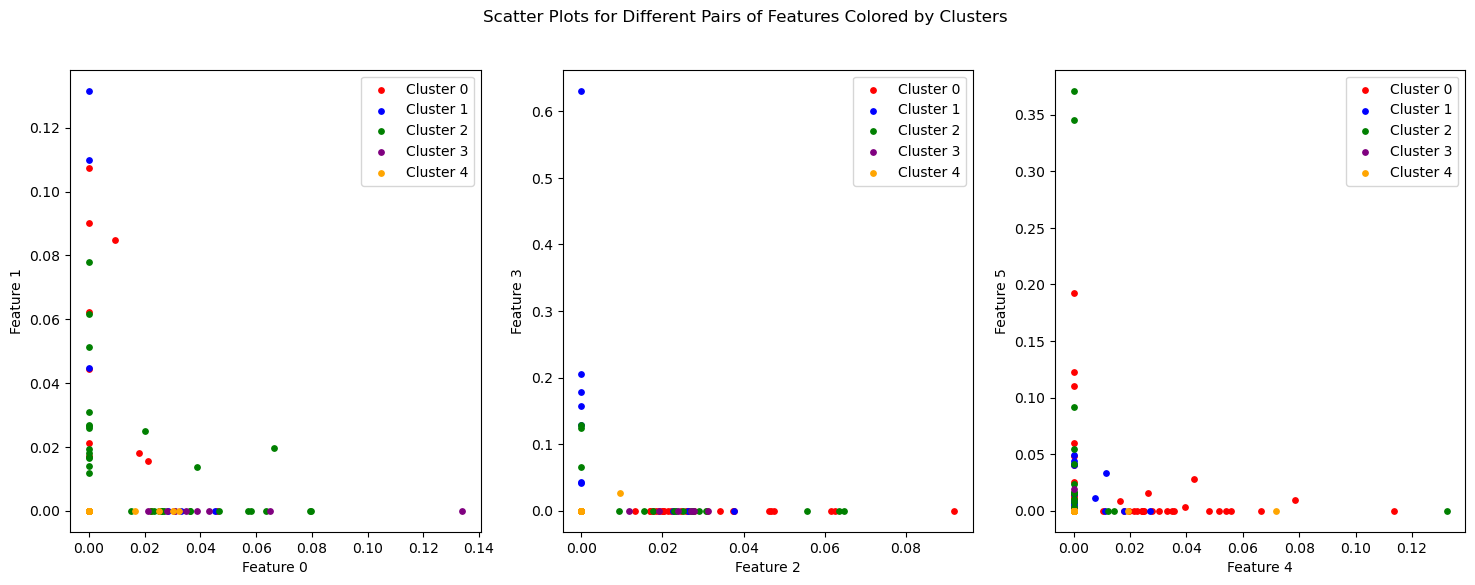

In [26]:
import matplotlib.pyplot as plt

# наши пары для визуализации
pairs_of_features = [(0, 1), (2, 3), (4, 5)]

plt.figure(figsize=(18, 6))
colors = ['red', 'blue', 'green', 'purple', 'orange']

for i, (feature_x, feature_y) in enumerate(pairs_of_features):
    plt.subplot(1, len(pairs_of_features), i + 1)
    for cluster in range(5):
        cluster_indices = np.where(labels == cluster)[0]
        plt.scatter(
            normalized_data[cluster_indices, feature_x], 
            normalized_data[cluster_indices, feature_y], 
            s=15, 
            c=colors[cluster], 
            label=f'Cluster {cluster}'
        )
    plt.xlabel(f'Feature {feature_x}')
    plt.ylabel(f'Feature {feature_y}')
    plt.legend()

plt.suptitle('Scatter Plots for Different Pairs of Features Colored by Clusters')
plt.show()

**Ответ:** Показывает разделение плохо, потому что у нас разделение строится по всем признакам, а мы смотрим только на пары, нужно использовать методы понижения пространства для лучшего визуального разделения, например t-SNE или PCA

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

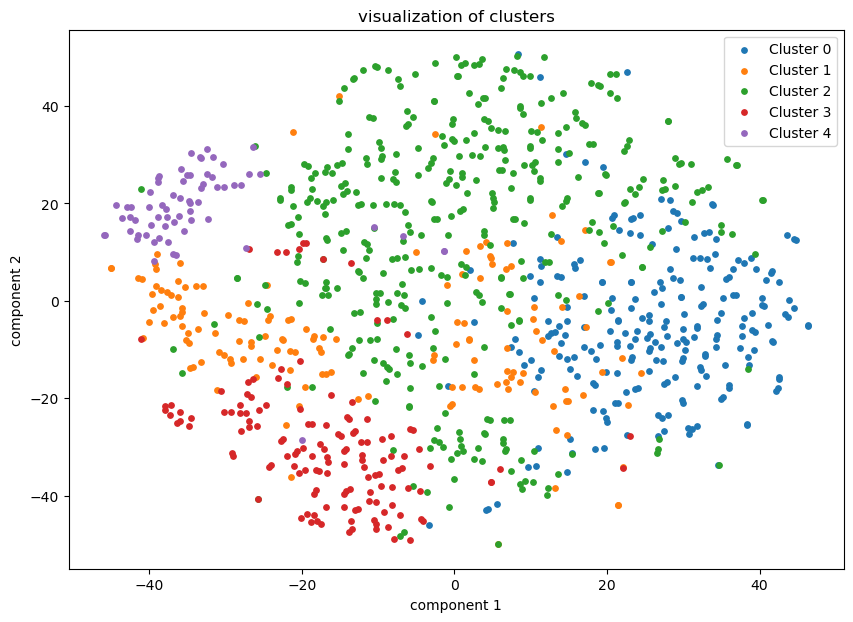

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(normalized_data)

plt.figure(figsize=(10, 7))

for cluster in range(5):
    cluster_indices = np.where(labels == cluster)[0]
    plt.scatter(
        tsne_results[cluster_indices, 0], 
        tsne_results[cluster_indices, 1], 
        s=15, 
        label=f'Cluster {cluster}'
    )

plt.title('visualization of clusters')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.legend()
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

Number of clusters: 2, Silhouette Score: 0.004435467122570446
Number of clusters: 3, Silhouette Score: 0.005315820445524468
Number of clusters: 4, Silhouette Score: 0.006557296738510863
Number of clusters: 5, Silhouette Score: 0.006837938191539541
Number of clusters: 6, Silhouette Score: 0.007482359393187096
Number of clusters: 7, Silhouette Score: 0.007912084817600716
Number of clusters: 8, Silhouette Score: 0.00699610257418764
Number of clusters: 9, Silhouette Score: 0.00692453596232229
Optimal number of clusters: 7


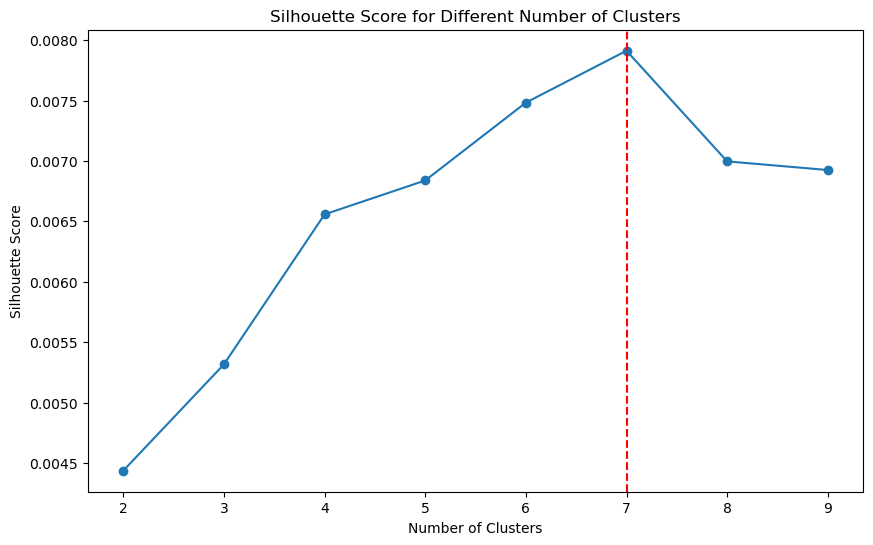

In [28]:
from sklearn.metrics import silhouette_score

cluster_range = range(2, 10)
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_data)
    silhouette_avg = silhouette_score(normalized_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg}")

optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_clusters}")

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Clusters')
plt.axvline(optimal_clusters, color='red', linestyle='--')
plt.show()

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [29]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(normalized_data)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [30]:
def find_closest_artists(centroids, data, n=10):
    closest_artists = []
    for centroid in centroids:
        distances = []
        for i in range(data.shape[0]):
            distance = cosine(centroid, data[i])
            distances.append((i, distance))
        distances.sort(key=lambda x: x[1])
        closest_artists.append(distances[:n])
    return closest_artists

closest_artists_indices = find_closest_artists(centroids, normalized_data)

for cluster_idx, artists in enumerate(closest_artists_indices):
    print(f"Cluster {cluster_idx + 1}:")
    for artist_idx, _ in artists:
        print(f" - {transposed_ratings.index[artist_idx]}")
    print()

Cluster 1:
 - nas
 - jay-z
 - kanye west
 - a tribe called quest
 - lupe the gorilla
 - the roots featuring d'angelo
 - mos def
 - little brother
 - gangstarr
 - talib kweli

Cluster 2:
 - the killers
 - radiohead
 - coldplay
 - white stripes
 - deathcab for cutie
 - red hot clili peppers
 - foo fighters
 - beck
 - the arctic monkeys
 - franz ferdinand

Cluster 3:
 - descendents
 - against me!
 - rancid
 - alkaline trio
 - the ramones
 - less than jake
 - the lawrence arms
 - jawbreaker
 - big d and the kids table
 - streetlight manifesto

Cluster 4:
 - metallica
 - koЯn
 - iron maiden
 - system of a down
 - mudvayne
 - as i lay dying
 - slayer
 - megadeth
 - pantera
 - killswitch engage

Cluster 5:
 - fall out boy
 - paramore
 - dashboard confesssional
 - cartel
 - the all-americian rejects
 - somethings corporate
 - the academy is...
 - the fray
 - anberlin
 - taking back sunday

Cluster 6:
 - animal collective
 - broken social scene
 - radiohead
 - the arcade fire
 - sufjan stevens


**Ответ:** Как будто смысл кластеров остался прежний, но более узконаправленный, например, в кластере 7 более классический рок, а в кластере 4 больше металл, раньше они были вместе. 

Сделайте t-SNE визуализацию полученной кластеризации.

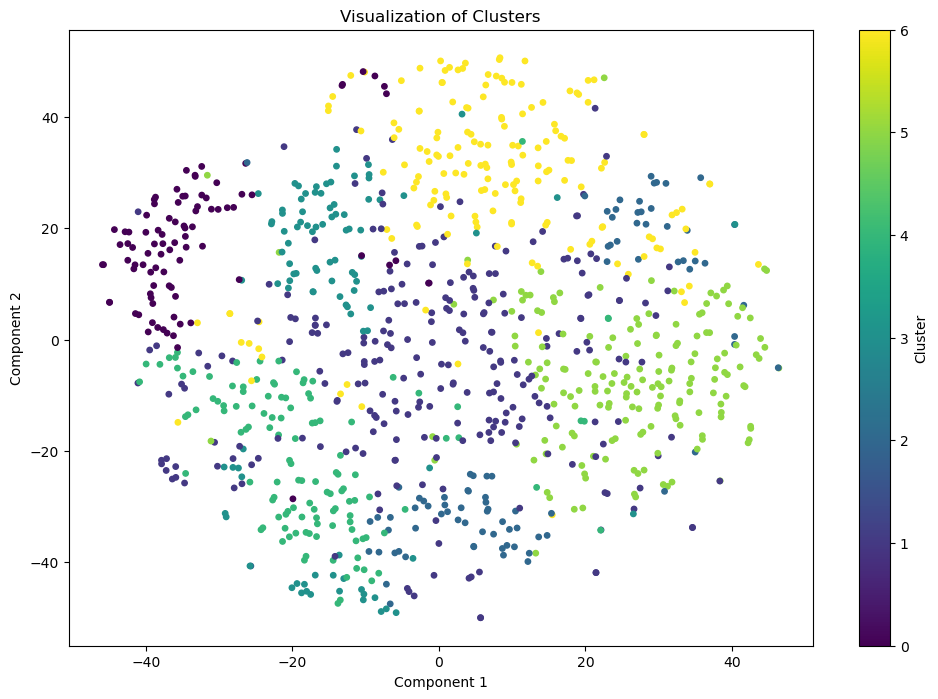

In [31]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(normalized_data)

plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', s=15)
plt.colorbar(label='Cluster')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Visualization of Clusters')
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

**Ответ:** Можно снова посмотреть на 7, тут он 6, кластер, и на 4, здесь он 3, они находятся близко друг к другу, на первой визуализации t-SNE они были соединены вместе, так как это рок, однако здесь разбились на поджанры